# Thesis Pipeline Integration Test

This notebook tests the complete end-to-end pipeline for the Bachelor Thesis. 
It integrates:
1. **Data Loading** (Tick data -> Hourly candles)
2. **Feature Engineering** (Technical Indicators)
3. **Rolling Window Validation** (Walk-Forward)
4. **Hyperparameter Optimization** (Optuna)
5. **Strategy Evaluation** (Sharpe Ratio, Max Drawdown)

In [1]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path

# Add project root to path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Import all core components
try:
    from src.dataloader.DataLoader import DataLoader
    from src.datawrapper.DataWrapper import DataWrapper
    from src.transformer.TechIndicGenerator import TechIndicGenerator
    from src.transformer.Scope import ScopeShifter
    from src.transformer.DataSelector import DataSelector
    from src.model.ScikitModel import ScikitModel
    from src.learner.Trainer import Trainer
    from src.learner.Tester import Tester
    from src.learner.Learner import UpdatingLearner
    from src.optimizer.Optimizer import Optimizer
    from src.utils.Evaluation import Metric, evaluate_metrics
    from src.simulation.Simulation import SimpleStrategy
    from sklearn.ensemble import RandomForestRegressor
    print("✅ All imports successful!")
except ImportError as e:
    print(f"❌ Import failed: {e}")

✅ All imports successful!


/home/artem/miniconda3/envs/ts-env/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("--- Step 1: Data Loading Verification ---")
csv_path = PROJECT_ROOT / 'btc_usdt_1h.csv' # Ensure this file exists

try:
    # 1. Load
    wrapper = DataLoader.load_wrap(str(csv_path), data_type='tick')
    df = wrapper.get_dataframe()
    
    # 2. Check Basic Structure
    assert not df.empty, "Dataframe is empty!"
    assert 'close' in df.columns, "Missing 'close' column"
    assert 'open_time_iso' in df.columns, "Missing 'open_time_iso'"
    
    # 3. Create Target (Log Return) if missing
    if 'log_return' not in df.columns:
        # Calculate next-period return for prediction
        wrapper.compute_log_return()
        # wrapper.drop_na() # Drop the last row which is now NaN
        
    print(f"✅ Data Loaded. Shape: {wrapper.get_dataframe().shape}")
    print(f"   Time Range: {df['open_time_iso'].min()} to {df['open_time_iso'].max()}")
    
except Exception as e:
    print(f"❌ Data Loading Failed: {e}")

--- Step 1: Data Loading Verification ---
✅ Data Loaded. Shape: (8804, 7)
   Time Range: 2024-12-15 00:00:00+00:00 to 2025-12-16 20:00:00+00:00


In [3]:
wrapper.get_dataframe().head()

,open_time_iso,open,high,low,close,volume,log_return
0,2024-12-15 00:00:00+00:00,101420.00,101558.83,101237.14,101442.42,313.78863,0.006799
1,2024-12-15 01:00:00+00:00,101442.41,102196.97,101424.01,102134.48,1458.80477,-0.002974
2,2024-12-15 02:00:00+00:00,102134.48,102155.28,101775.88,101831.15,728.33298,-0.000956
3,2024-12-15 03:00:00+00:00,101831.16,101931.73,101722.31,101733.82,216.32352,0.006196
4,2024-12-15 04:00:00+00:00,101733.83,102850.00,101733.82,102366.17,1788.48948,-0.002023


In [4]:
print("\n--- Step 2: Feature Engineering Verification ---")

try:
    gen = TechIndicGenerator()
    initial_cols = len(wrapper.get_dataframe().columns)
    
    # Add Indicators
    gen.compute_RSI(wrapper, period=14)
    gen.compute_BBANDS(wrapper)
    gen.compute_ATR(wrapper)
    
    new_cols = len(wrapper.get_dataframe().columns)
    df = wrapper.get_dataframe()
    
    # Checks
    assert new_cols > initial_cols, f"No new columns added! ({initial_cols} -> {new_cols})"
    assert 'rsi' in df.columns, "RSI column missing"
    assert 'bb_upper' in df.columns, "Bollinger Bands missing"
    assert df.isnull().sum().sum() == 0, "NaNs found in dataset after feature generation"
    
    print(f"✅ Features Added. New Shape: {df.shape}")
    print(f"   Columns Added: {list(set(df.columns) - set(['open', 'high', 'low', 'close', 'volume', 'open_time_iso', 'log_return']))}")

except Exception as e:
    print(f"❌ Feature Generation Failed: {e}")


--- Step 2: Feature Engineering Verification ---
✅ Features Added. New Shape: (8757, 12)
   Columns Added: ['bb_lower', 'atr', 'bb_upper', 'rsi', 'bb_middle']


In [5]:
print("\n--- Step 3: Rolling Window Verification ---")

try:
    # Define a small window for testing
    window_size = "5d"
    step_size = "1d"
    
    scope = ScopeShifter(
        wrapper=wrapper, 
        parameters={'window_size': window_size, 'step_size': step_size}
    )
    
    # Check Initial State
    assert scope.is_in_scope(), "Scope initiated out of bounds"
    start_1 = scope.start_value
    
    # Shift Window
    scope.shift()
    start_2 = scope.start_value
    
    # Verify Shift
    expected_shift = pd.Timedelta(step_size)
    actual_shift = pd.to_datetime(start_2) - pd.to_datetime(start_1)
    
    assert actual_shift == expected_shift, f"Shift incorrect. Expected {expected_shift}, got {actual_shift}"
    
    # Reset for next steps
    scope.reset_state()
    print(f"✅ Scope Logic Verified. Window: {window_size}, Step: {step_size}")

except Exception as e:
    print(f"❌ Scope Verification Failed: {e}")


--- Step 3: Rolling Window Verification ---
[WindowScope] Initialized with start: 2024-12-16 23:00:00, end: 2025-12-16 19:00:00, step_size: 1 days 00:00:00, window_size: 5 days 00:00:00
✅ Scope Logic Verified. Window: 5d, Step: 1d


In [6]:
print("\n--- Step 4: Data Selector Verification ---")

try:
    # Configure Selector
    selector = DataSelector(
        wrapper=wrapper, 
        training_scope=scope,
        test_parameters={'testing_window_size': "1d"} # Test on next 1 day
    )
    
    # Get Split
    train_data = selector.get_train_data()
    test_data = selector.get_test_data()
    
    # Checks
    assert not train_data.get_dataframe().empty, "Train data is empty"
    assert not test_data.get_dataframe().empty, "Test data is empty"
    
    # Check Disjointness (Train End <= Test Start)
    train_end = pd.to_datetime(train_data.get_dataframe()['open_time_iso']).max()
    test_start = pd.to_datetime(test_data.get_dataframe()['open_time_iso']).min()
    
    assert train_end < test_start, f"Data Leakage! Train End ({train_end}) >= Test Start ({test_start})"
    
    print(f"✅ Data Splitting Verified.")
    print(f"   Train Size: {len(train_data.get_dataframe())}, Test Size: {len(test_data.get_dataframe())}")

except Exception as e:
    print(f"❌ Data Selector Failed: {e}")


--- Step 4: Data Selector Verification ---
[WindowScope] Initialized with start: 2024-12-16 23:00:00, end: 2025-12-16 19:00:00, step_size: 1 days 00:00:00, window_size: 30 days 00:00:00
✅ Data Splitting Verified.
   Train Size: 120, Test Size: 24


In [7]:
print("Starting Walk-Forward Validation...")

iteration = 0
while not selector.is_last_window():
    iteration += 1
    
    # PRINT FROM SELECTOR (not from 'scope')
    info = selector.current_state_info() 
    print(f"Iter {iteration}: Train Indices={info['train_indices']} | Test Indices={info['test_indices']}")
    
    # 3. Update
    selector.update()
    
    # Safety break for testing
    if iteration > 30: 
        break

Starting Walk-Forward Validation...
Iter 1: Train Indices=(Timestamp('2024-12-16 23:00:00'), Timestamp('2024-12-21 23:00:00')) | Test Indices=(Timestamp('2024-12-21 23:00:00'), Timestamp('2024-12-22 23:00:00'))
Iter 2: Train Indices=(Timestamp('2024-12-17 23:00:00'), Timestamp('2024-12-22 23:00:00')) | Test Indices=(Timestamp('2024-12-22 23:00:00'), Timestamp('2024-12-23 23:00:00'))
Iter 3: Train Indices=(Timestamp('2024-12-18 23:00:00'), Timestamp('2024-12-23 23:00:00')) | Test Indices=(Timestamp('2024-12-23 23:00:00'), Timestamp('2024-12-24 23:00:00'))
Iter 4: Train Indices=(Timestamp('2024-12-19 23:00:00'), Timestamp('2024-12-24 23:00:00')) | Test Indices=(Timestamp('2024-12-24 23:00:00'), Timestamp('2024-12-25 23:00:00'))
Iter 5: Train Indices=(Timestamp('2024-12-20 23:00:00'), Timestamp('2024-12-25 23:00:00')) | Test Indices=(Timestamp('2024-12-25 23:00:00'), Timestamp('2024-12-26 23:00:00'))
Iter 6: Train Indices=(Timestamp('2024-12-21 23:00:00'), Timestamp('2024-12-26 23:00:00')

In [8]:
train_data.get_dataframe()

,open_time_iso,open,high,low,close,volume,log_return,rsi,bb_upper,bb_middle,bb_lower,atr
0,2024-12-16 23:00:00+00:00,105816.00,106064.00,105480.02,106058.66,756.03796,-0.001908,59.518741,107496.572851,105410.0555,103323.538149,914.465714
1,2024-12-17 00:00:00+00:00,106058.65,106244.40,105657.34,105856.51,1086.89201,0.004895,57.251333,107536.159948,105468.5735,103400.987052,891.079592
2,2024-12-17 01:00:00+00:00,105856.51,106469.29,105744.62,106376.00,1112.03906,-0.001005,61.328471,107629.441018,105535.9735,103442.505982,879.193192
3,2024-12-17 02:00:00+00:00,106376.01,106590.55,106197.74,106269.14,804.33118,0.005605,60.059542,107700.909803,105591.9315,103482.953197,844.451536
4,2024-12-17 03:00:00+00:00,106269.15,107000.00,106240.50,106866.49,879.61902,-0.003428,64.483435,107845.659956,105685.6165,103525.573044,838.383569
...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-12-21 18:00:00+00:00,97595.29,97723.18,97287.87,97400.01,378.39640,-0.001346,48.100316,99020.498877,97830.1330,96639.767123,819.449988
116,2024-12-21 19:00:00+00:00,97400.01,97436.69,96819.36,97269.03,741.60788,0.001930,46.934275,99018.606263,97803.3125,96588.018737,805.012846
117,2024-12-21 20:00:00+00:00,97269.03,98057.51,97224.83,97456.91,882.07806,-0.005813,48.849739,99018.674031,97799.8695,96581.064969,806.989071
118,2024-12-21 21:00:00+00:00,97456.92,97577.99,96539.91,96892.00,703.06094,0.002633,43.737646,99045.063579,97776.6080,96508.152421,823.495566


In [9]:
train_data.get_labels()

,log_return
0,-0.001908
1,0.004895
2,-0.001005
3,0.005605
4,-0.003428
...,...
115,-0.001346
116,0.001930
117,-0.005813
118,0.002633


In [10]:
print("\n--- Step 5: Single Step Training Verification ---")

try:
    # Initialize Model
    rf = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
    model = ScikitModel(rf)
    
    # Initialize Trainer/Tester
    trainer = Trainer(model=model)
    tester = Tester(model=model)
    
    # Train
    trainer.train(train_data)
    
    # Predict
    preds = tester.test(test_data)
    
    # Checks
    assert not preds.empty, "Predictions are empty"
    assert len(preds) == len(test_data.get_dataframe()), "Prediction length mismatch"
    assert preds.isna().sum().sum() == 0, "NaNs in predictions"
    
    print(f"✅ Model Fit & Predict Verified.")
    print(f"   Prediction Sample: {preds.iloc[0].values}")

except Exception as e:
    print(f"❌ Training Step Failed: {e}")


--- Step 5: Single Step Training Verification ---


✅ Model Fit & Predict Verified.
   Prediction Sample: [0.00110542]


In [11]:
print("\n--- Step 6: Walk-Forward Learner Verification ---")

try:
    # Re-init Selector to reset state
    scope.reset_state()
    selector = DataSelector(
        wrapper=wrapper, 
        training_scope=scope,
        test_parameters={'testing_window_size': "1d"}
    )

except Exception as e:
    print(f"❌ Learner Failed: {e}")


--- Step 6: Walk-Forward Learner Verification ---
[WindowScope] Initialized with start: 2024-12-16 23:00:00, end: 2025-12-16 19:00:00, step_size: 1 days 00:00:00, window_size: 30 days 00:00:00


In [12]:
print("Starting Walk-Forward Validation...")

iteration = 0
while not selector.is_last_window():
    iteration += 1
    
    # PRINT FROM SELECTOR (not from 'scope')
    info = selector.current_state_info() 
    print(f"Iter {iteration}: Train Indices={info['train_indices']} | Test Indices={info['test_indices']}")
    
    # 3. Update
    selector.update()
    
    # Safety break for testing
    if iteration > 30: 
        break

Starting Walk-Forward Validation...
Iter 1: Train Indices=(Timestamp('2024-12-16 23:00:00'), Timestamp('2024-12-21 23:00:00')) | Test Indices=(Timestamp('2024-12-21 23:00:00'), Timestamp('2024-12-22 23:00:00'))
Iter 2: Train Indices=(Timestamp('2024-12-17 23:00:00'), Timestamp('2024-12-22 23:00:00')) | Test Indices=(Timestamp('2024-12-22 23:00:00'), Timestamp('2024-12-23 23:00:00'))
Iter 3: Train Indices=(Timestamp('2024-12-18 23:00:00'), Timestamp('2024-12-23 23:00:00')) | Test Indices=(Timestamp('2024-12-23 23:00:00'), Timestamp('2024-12-24 23:00:00'))
Iter 4: Train Indices=(Timestamp('2024-12-19 23:00:00'), Timestamp('2024-12-24 23:00:00')) | Test Indices=(Timestamp('2024-12-24 23:00:00'), Timestamp('2024-12-25 23:00:00'))
Iter 5: Train Indices=(Timestamp('2024-12-20 23:00:00'), Timestamp('2024-12-25 23:00:00')) | Test Indices=(Timestamp('2024-12-25 23:00:00'), Timestamp('2024-12-26 23:00:00'))
Iter 6: Train Indices=(Timestamp('2024-12-21 23:00:00'), Timestamp('2024-12-26 23:00:00')

In [13]:
learner = UpdatingLearner(
    trainer=trainer,
    tester=tester,
    data_wrapper=wrapper,
    data_selector=selector
)

# Run (Compute)
# This runs the loop: Train -> Predict -> Shift -> Repeat
result_wrapper = learner.compute()
res_df = result_wrapper.get_dataframe()

# Checks
assert 'prediction' in res_df.columns, "Prediction column missing in result wrapper"
# Note: Not all rows will have predictions (start of dataset is used for initial training only)
pred_count = res_df['prediction'].notna().sum()

assert pred_count > 0, "No predictions generated in Walk-Forward loop"

print(f"✅ Walk-Forward Loop Verified.")
print(f"   Total Predictions Generated: {pred_count} out of {len(res_df)} rows")

✅ Walk-Forward Loop Verified.
   Total Predictions Generated: 8637 out of 8637 rows


In [14]:
print("\n--- Step 7: Optimization Verification ---")

try:
    # Small search space for quick check
    search_space = {
        'n_estimators': ('int', 5, 10),
        'max_depth': ('int', 2, 5)
    }
    
    optimizer = Optimizer(
        wrapper=wrapper,
        learner=learner,
        metric=Metric.SHARPE_RATIO,
        search_space=search_space,
        n_trials=2, # Very small number just to test functionality
        direction="maximize"
    )
    
    optimizer.run()
    
    assert optimizer.best_params != {}, "No best params found"
    
    print(f"✅ Optimization Verified.")
    print(f"   Best Params: {optimizer.best_params}")
    print(f"   Best Sharpe: {optimizer.best_value}")

except Exception as e:
    print(f"❌ Optimization Failed: {e}")

[I 2026-01-22 23:08:16,839] A new study created in memory with name: no-name-736ba452-84a2-4ffd-a856-aa69d5947eed



--- Step 7: Optimization Verification ---


[I 2026-01-22 23:08:21,557] Trial 0 finished with value: 0.12373100171408694 and parameters: {'n_estimators': 5, 'max_depth': 2}. Best is trial 0 with value: 0.12373100171408694.


Trial 0: {'n_estimators': 5, 'max_depth': 2}, sharpe_ratio = 0.1237


[I 2026-01-22 23:08:28,494] Trial 1 finished with value: 0.1639813704059199 and parameters: {'n_estimators': 9, 'max_depth': 4}. Best is trial 1 with value: 0.1639813704059199.


Trial 1: {'n_estimators': 9, 'max_depth': 4}, sharpe_ratio = 0.1640
✅ Optimization Verified.
   Best Params: {'n_estimators': 9, 'max_depth': 4}
   Best Sharpe: 0.1639813704059199


In [15]:
print("\n--- Step 8: Simulation & Evaluation Verification ---")

try:
    # Use the results from Step 6
    if 'prediction' not in res_df.columns:
        raise ValueError("Run Step 6 first to generate predictions")
        
    metrics, info = evaluate_metrics(res_df)
    
    # Checks
    required_metrics = ['sharpe_ratio', 'total_return', 'max_drawdown']
    for m in required_metrics:
        assert m in metrics, f"Missing metric: {m}"
        
    assert isinstance(metrics['sharpe_ratio'], float), "Sharpe ratio is not a float"
    
    # Strategy Check
    strategy = SimpleStrategy(result_wrapper)
    sim_metrics = strategy.run(res_df['prediction'])
    
    print(f"✅ Evaluation Verified.")
    print(f"   Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
    print(f"   Max Drawdown: {metrics['max_drawdown']:.4f}")

except Exception as e:
    print(f"❌ Evaluation Failed: {e}")


--- Step 8: Simulation & Evaluation Verification ---
✅ Evaluation Verified.
   Sharpe Ratio: 0.2212
   Max Drawdown: -0.0014


In [16]:
result_wrapper.get_dataframe().head(50)

,open_time_iso,open,high,low,close,volume,log_return,rsi,bb_upper,bb_middle,bb_lower,atr,prediction
120,2024-12-21 23:00:00+00:00,97147.46,97313.26,96900.00,97291.99,374.62991,-0.000401,48.002281,99053.426617,97754.4075,96455.388383,791.042146,0.001105
121,2024-12-22 00:00:00+00:00,97292.00,97448.08,97052.00,97253.01,422.37636,-0.001986,47.605476,99053.359365,97737.6580,96421.956635,762.830565,0.000197
122,2024-12-22 01:00:00+00:00,97253.01,97432.69,96720.00,97060.01,447.72923,-0.003509,45.595740,98926.544481,97656.0595,96385.574519,759.249096,0.000505
123,2024-12-22 02:00:00+00:00,97060.00,97236.18,96613.18,96719.99,371.81103,0.002833,42.214503,98788.533289,97555.7210,96322.908711,749.517017,0.000718
124,2024-12-22 03:00:00+00:00,96719.99,97320.00,96549.37,96994.37,606.61122,-0.009513,45.712988,98502.432482,97453.4395,96404.446518,751.025088,0.001105
125,2024-12-22 04:00:00+00:00,96994.37,97071.97,96072.00,96076.01,713.47180,0.000834,37.524229,98386.457020,97324.7400,96263.022980,768.806867,0.002578
126,2024-12-22 05:00:00+00:00,96076.01,96409.64,95890.28,96156.19,1122.09453,0.006053,38.559071,98221.227414,97204.2585,96187.289586,750.989234,0.001875
127,2024-12-22 06:00:00+00:00,96156.19,96749.99,96112.00,96739.99,591.16867,-0.005491,45.621763,98076.040766,97134.6970,96193.353234,742.917860,0.002578
128,2024-12-22 07:00:00+00:00,96740.00,96847.99,96080.00,96210.24,554.68137,0.003365,41.014514,97904.316714,97032.1050,96159.893286,744.708727,0.002578
129,2024-12-22 08:00:00+00:00,96210.25,96689.55,96196.85,96534.50,503.87812,0.004195,44.696080,97899.286840,97002.2305,96105.174160,726.708104,0.002578


In [17]:
strategy.market_data

,open_time_iso,open,high,low,close,volume,log_return,rsi,bb_upper,bb_middle,bb_lower,atr,prediction,market_return,signal,shifted_signal,strategy_return
120,2024-12-21 23:00:00+00:00,97147.46,97313.26,96900.00,97291.99,374.62991,-0.000401,48.002281,99053.426617,97754.4075,96455.388383,791.042146,0.001105,-0.000401,0.001105,NaN,-0.000000e+00
121,2024-12-22 00:00:00+00:00,97292.00,97448.08,97052.00,97253.01,422.37636,-0.001986,47.605476,99053.359365,97737.6580,96421.956635,762.830565,0.000197,-0.001986,0.000197,0.001105,-2.195909e-06
122,2024-12-22 01:00:00+00:00,97253.01,97432.69,96720.00,97060.01,447.72923,-0.003509,45.595740,98926.544481,97656.0595,96385.574519,759.249096,0.000505,-0.003509,0.000505,0.000197,-6.921672e-07
123,2024-12-22 02:00:00+00:00,97060.00,97236.18,96613.18,96719.99,371.81103,0.002833,42.214503,98788.533289,97555.7210,96322.908711,749.517017,0.000718,0.002833,0.000718,0.000505,1.431913e-06
124,2024-12-22 03:00:00+00:00,96719.99,97320.00,96549.37,96994.37,606.61122,-0.009513,45.712988,98502.432482,97453.4395,96404.446518,751.025088,0.001105,-0.009513,0.001105,0.000718,-6.830711e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8752,2025-12-16 15:00:00+00:00,87298.00,88175.98,86839.35,87977.43,1924.39377,-0.004433,59.765677,87616.322320,86424.9415,85233.560680,766.726138,-0.005619,-0.004433,-0.005619,-0.005619,2.491093e-05
8753,2025-12-16 16:00:00+00:00,87977.44,88050.17,87333.08,87588.26,1300.81662,-0.005223,55.290797,87770.479559,86515.0025,85259.525441,763.180700,-0.001376,-0.005223,-0.001376,-0.005619,2.934737e-05
8754,2025-12-16 17:00:00+00:00,87588.26,87844.01,87093.79,87131.99,779.27901,0.007425,50.515289,87836.031918,86559.4130,85282.794082,762.254935,-0.001659,0.007425,-0.001659,-0.001376,-1.021847e-05
8755,2025-12-16 18:00:00+00:00,87132.00,88019.88,87061.23,87781.35,863.99314,-0.002231,56.300174,88009.270236,86635.5150,85261.759764,776.283154,-0.001659,-0.002231,-0.001659,-0.001659,3.701164e-06


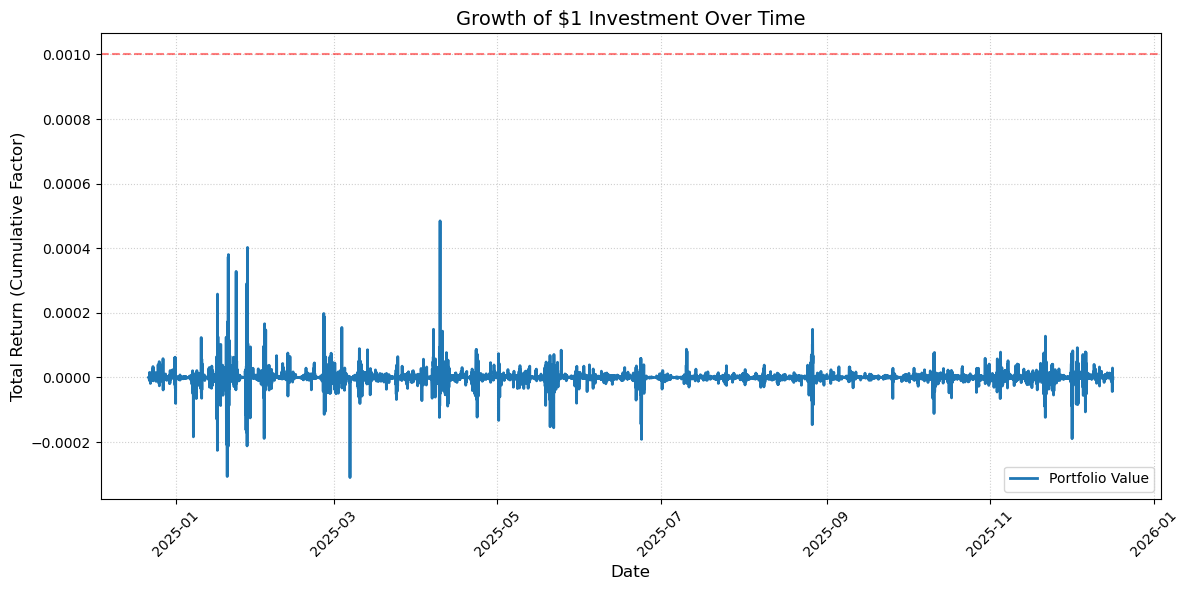

In [18]:
import matplotlib.pyplot as plt

# 3. Visualization
plt.figure(figsize=(12, 6))
plt.plot(strategy.market_data['open_time_iso'],strategy.market_data['strategy_return'], color='#1f77b4', linewidth=2, label='Portfolio Value')

# Adding a horizontal line at 1.0 to show the break-even point
plt.axhline(y=.001, color='red', linestyle='--', alpha=0.5)

# Formatting the chart
plt.title('Growth of $1 Investment Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Return (Cumulative Factor)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()